In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import matplotlib.pyplot as plt

In [31]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [32]:
class_names = ['glioma', 'menin', 'tumor']

In [33]:
image_data = np.load('image_data.npy')
image_labels = np.load('image_labels.npy')

# update shape to match PyTorch's format (Examples, Channels, Height, Width)
updated_image_data_temp = np.swapaxes(image_data, 1, 3)
updated_image_data = np.swapaxes(updated_image_data_temp, 2, 3)

print('Orginal shape: ', image_data.shape)
print('New shape: ', updated_image_data.shape)

Orginal shape:  (6056, 256, 256, 3)
New shape:  (6056, 3, 256, 256)


In [34]:
#LAST MODIFICATION --> Reverted back to 1 FC layer
model_one = nn.Sequential(
    # First conv
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5), # 3 --> 32
    nn.ReLU(),

    # second conv layer
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), # 32 --> 32 channels
    nn.ReLU(),
    nn.BatchNorm2d(32), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2
    nn.Dropout2d(0.1), # remove 10% for regularization

    # third conv layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 64
    nn.ReLU(), # activation
    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
    nn.Dropout2d(0.2), # remove 20% for regularization

    nn.AdaptiveAvgPool2d((4, 4)), # Avg pooling into 4x4 to reduce size
    
    nn.Flatten(), # drop to 1D
    nn.Linear(64*16, 128), # fully connected layer
    nn.ReLU(), # activation
    nn.Dropout(0.4),

    nn.Linear(128, len(class_names)) # Prediction Layer
)

# LAST MODIFICATION: Reduced first FC dropout from 20 --> 10
model_two = nn.Sequential(
    # first conv layer
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5), # 3 --> 32 channels (input layer)
    nn.ReLU(),
    
    # second conv layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 32 --> 32 channels (input layer)
    nn.ReLU(),

    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2

    # this is a test of a setup from literature (Srinivasan et al., 2024)
    nn.ReLU(), # extra level of activation to add complexity without convolutional 
    nn.Dropout2d(0.1), # remove 10% for regularization (not in papers setup)
    nn.BatchNorm2d(64), 
    nn.MaxPool2d((2, 2)),

    # second conv layer
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5), # 64 --> 64
    nn.ReLU(), # activation

    nn.BatchNorm2d(64), # noramalization
    nn.MaxPool2d((2, 2)), # pooling into 2x2 frames
    nn.Dropout2d(0.15), # remove 15% for regularization

    nn.AdaptiveAvgPool2d((1, 1)), # Avg pooling into 4x4 to reduce size
    
    nn.Flatten(), # force to 1D
    nn.Linear(64, 32), # fully connected layer
    nn.ReLU(), # activation
    nn.Dropout(0.1), # remove 10% for regularization

    nn.Linear(32, 16), # hidden FC layer
    nn.ReLU(),
    nn.Dropout(0.5), # 50% dropout

    nn.Linear(16, len(class_names)) # Prediction Layer
)

# set to GPU for acceleration
mps_device = torch.device("mps")
model_one.to(mps_device)
model_two.to(mps_device)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout2d(p=0.1, inplace=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (11): ReLU()
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Dropout2d(p=0.15, inplace=False)
  (15): AdaptiveAvgPool2d(output_size=(1, 1))
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=64, out_features=32, bias=T

In [35]:
# class for custom dataset needed for pytorch 
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# create train test splits
x_train_one, x_test_one, y_train_one, y_test_one = train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=12, shuffle=True)
x_train_two, x_test_two, y_train_two, y_test_two= train_test_split(updated_image_data, image_labels, test_size=0.2, random_state=12, shuffle=True)

# ecode labels numerically
label_encoder = LabelEncoder() 
y_train_one = label_encoder.fit_transform(y_train_one)
y_test_one = label_encoder.transform(y_test_one)
print(y_test_one)

y_train_two = label_encoder.transform(y_train_two)
y_test_two = label_encoder.transform(y_test_two)

# create custom dataset objects for train and test sets
train_set_one = CustomDataset(x_train_one, y_train_one)
test_set_one = CustomDataset(x_test_one, y_test_one)

train_set_two = CustomDataset(x_train_two, y_train_two)
test_set_two = CustomDataset(x_test_two, y_test_two)


[0 2 2 ... 0 2 2]


In [36]:
# create loaders for batches
training_loader_one = DataLoader(train_set_one, batch_size=10, shuffle=True)
validation_loader_one = DataLoader(test_set_one, batch_size=10, shuffle=False)

training_loader_two = DataLoader(train_set_two, batch_size=10, shuffle=True)
validation_loader_two = DataLoader(test_set_two, batch_size=10, shuffle=False)

# set loss and opimizer functions
loss_fn = nn.CrossEntropyLoss()
optimizer_one = torch.optim.Adam(model_one.parameters(), lr = 0.0002)
optimizer_two = torch.optim.Adam(model_two.parameters(), lr = 0.0002)


In [37]:
# code for training on single epoch MODEL1
def train_single_epoch_one(epoch_index, tb_writer):
    running_loss_one = 0.0
    total_loss_one = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(training_loader_one):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer_one.zero_grad()

        # Make predictions
        outputs = model_one(inputs)

        # Compute loss and gradients
        loss_one = loss_fn(outputs, labels)
        loss_one.backward()

        # Adjust learning weights
        optimizer_one.step()

        # Accumulate losses
        batch_loss = loss_one.item()
        running_loss_one += batch_loss
        total_loss_one += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_one = running_loss_one / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_one))
            tb_x = epoch_index * len(training_loader_one) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_one, tb_x)
            running_loss_one = 0.0  # RESET after reporting!
    
    # Return average loss for entire epoch
    epoch_loss_one = total_loss_one / len(training_loader_one.dataset)
    return epoch_loss_one

# code for training on single epoch MODEL2
def train_single_epoch_two(epoch_index, tb_writer):
    running_loss_two = 0.0
    total_loss_two = 0.0  # Track total for the entire epoch
    
    for i, data in enumerate(training_loader_two):
        inputs, labels = data
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        
        # Zero gradients
        optimizer_two.zero_grad()

        # Make predictions
        outputs = model_two(inputs)

        # Compute loss and gradients
        loss_two = loss_fn(outputs, labels)
        loss_two.backward()

        # Adjust learning weights
        optimizer_two.step()

        # Accumulate losses
        batch_loss = loss_two.item()
        running_loss_two += batch_loss
        total_loss_two += batch_loss * inputs.size(0)  # Scale by batch size
        
        # Report every 1000 batches
        if i % 1000 == 999:
            avg_loss_two = running_loss_two / 1000
            print('  batch {} loss: {:.4f}'.format(i + 1, avg_loss_two))
            tb_x = epoch_index * len(training_loader_two) + i + 1
            tb_writer.add_scalar('Loss/train', avg_loss_two, tb_x)
            running_loss_two = 0.0  # ← RESET after reporting!
    
    # Return average loss for entire epoch
    epoch_loss_two = total_loss_two / len(training_loader_two.dataset)
    return epoch_loss_two

In [38]:
# TRAINING LOOP!
epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer_one = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
writer_two = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 150
best_vloss_one = 1_000_000.
best_vloss_two = 1_000_000.


true_labels_list_one = []
predicted_labels_list_one = []
train_loss_list_one = []
val_loss_list_one = []
val_accuracy_one = []
val_probs_one  = []


true_labels_list_two = []
predicted_labels_list_two = []
train_loss_list_two = []
val_loss_list_two = []
val_accuracy_two = []
val_probs_two = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number +1))

    model_one.train(True)
    model_two.train(True)

    avg_loss_one = train_single_epoch_one(epoch_number, writer_one)
    avg_loss_two = train_single_epoch_two(epoch_number, writer_two)

    running_vloss_one = 0.0
    running_vloss_two = 0.0

    model_one.eval()
    model_two.eval()


    with torch.no_grad():
        # val one
        for i, vdata in enumerate(validation_loader_one):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = model_one(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss_one += vloss

            true_labels_list_one.extend(vlabels.cpu().numpy())
            predicted_labels_list_one.extend(predicted.cpu().numpy())
            # data for ROC_curve
            probabilities = nn.functional.softmax(voutputs, dim=1)
            val_probs_one.extend(probabilities.cpu().numpy())

        #val two
        for i, vdata in enumerate(validation_loader_two):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(mps_device)
            vlabels = vlabels.to(mps_device)
            voutputs = model_two(vinputs)
            _, predicted = torch.max(voutputs, 1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss_two += vloss

            true_labels_list_two.extend(vlabels.cpu().numpy())
            predicted_labels_list_two.extend(predicted.cpu().numpy())

            # data for ROC_curve
            probabilities = nn.functional.softmax(voutputs, dim=1)
            val_probs_two.extend(probabilities.cpu().numpy())

    val_accuracy_one.append(metrics.accuracy_score(true_labels_list_one, predicted_labels_list_one))            
    val_accuracy_two.append(metrics.accuracy_score(true_labels_list_two, predicted_labels_list_two))
    
    avg_vloss_one = running_vloss_one / (i + 1)
    avg_vloss_two = running_vloss_two / (i + 1)

    print('Model 1 Loss train {} valid {}'.format(avg_loss_one, avg_vloss_one))
    print('Model 2 Loss train {} valid {}'.format(avg_loss_two, avg_vloss_two))

    val_loss_list_one.append(avg_vloss_one)
    val_loss_list_two.append(avg_vloss_two)

    train_loss_list_one.append(avg_loss_one)
    train_loss_list_two.append(avg_loss_two)

    writer_one.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_one, 'Validation' : avg_vloss_one},
                       epoch_number + 1)
    
    writer_two.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss_two, 'Validation' : avg_vloss_two},
                       epoch_number + 1)
    
    writer_one.flush()
    writer_two.flush()

    if avg_vloss_one < best_vloss_one:
        best_vloss_one = avg_vloss_one
        model_path = 'model_one_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_one.state_dict(), model_path)

    if avg_vloss_two < best_vloss_two:
        best_vloss_two = avg_vloss_two
        model_path = 'model_two_{}_{}'.format(timestamp, epoch_number)
        torch.save(model_two.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1:
Model 1 Loss train 0.6447794724849509 valid 0.5812963843345642
Model 2 Loss train 0.8850995647720223 valid 0.7024213671684265
EPOCH 2:
Model 1 Loss train 0.514213207223192 valid 0.5126227736473083
Model 2 Loss train 0.6254039705045749 valid 0.971341609954834
EPOCH 3:
Model 1 Loss train 0.4187149337449047 valid 1.0659602880477905
Model 2 Loss train 0.528306188641699 valid 0.5441758036613464
EPOCH 4:
Model 1 Loss train 0.34229797125939343 valid 0.2655653655529022
Model 2 Loss train 0.4981494506099665 valid 0.5552363991737366
EPOCH 5:
Model 1 Loss train 0.3022992314615469 valid 0.3559972643852234
Model 2 Loss train 0.4433924466968321 valid 1.4671741724014282
EPOCH 6:
Model 1 Loss train 0.27888125210422116 valid 0.23929305374622345
Model 2 Loss train 0.48891695489157927 valid 0.33864593505859375
EPOCH 7:
Model 1 Loss train 0.251317766261257 valid 0.38343727588653564
Model 2 Loss train 0.4260800072814097 valid 0.38918328285217285
EPOCH 8:
Model 1 Loss train 0.2390053617494207 valid

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     55650
         1.0       0.92      0.92      0.92     61650
         2.0       0.95      0.95      0.95     64500

    accuracy                           0.94    181800
   macro avg       0.94      0.94      0.94    181800
weighted avg       0.94      0.94      0.94    181800

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     55650
         1.0       0.95      0.92      0.93     61650
         2.0       0.95      0.97      0.96     64500

    accuracy                           0.95    181800
   macro avg       0.95      0.95      0.95    181800
weighted avg       0.95      0.95      0.95    181800

<class 'int'>
<class 'int'>
<class 'int'>
{0: 0.9964599594245074, 1: 0.9861594217015159, 2: 0.9935261712167173} {0: 0.9969135453557728, 1: 0.9886211655544114, 2: 0.9924948987225493}


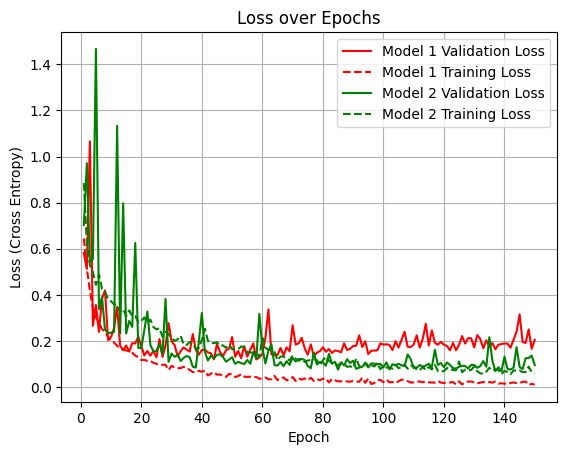

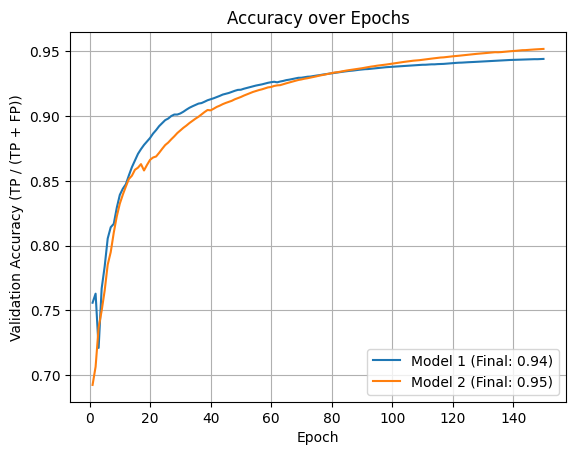

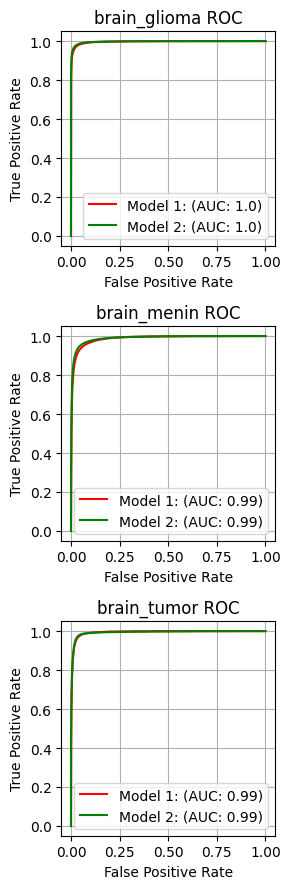

In [42]:
# run class report on model one
class_report_one = metrics.classification_report(true_labels_list_one, predicted_labels_list_one)
print(class_report_one)
# run class report on model two
class_report_two = metrics.classification_report(true_labels_list_two, predicted_labels_list_two)
print(class_report_two)

# move loss values from gpu back to cpu
val_losses_one = []
for loss in val_loss_list_one:
    val_losses_one.append(loss.cpu())

val_losses_two = []
for loss in val_loss_list_two:
    val_losses_two.append(loss.cpu())

# false positive rates dict
fpr_one = dict()
fpr_two = dict()
# true positive rates dict
tpr_one = dict()
tpr_two = dict()
#  ROC AUCs d
ROC_auc_one = dict()
ROC_auc_two = dict()

true_labels_list_one = np.array(true_labels_list_one)
true_labels_list_two = np.array(true_labels_list_two)

val_probs_one = np.array(val_probs_one)
val_probs_two = np.array(val_probs_two)

#ROC calculations
for class_index in range(len(class_names)):
    binary_true_labels_one = (true_labels_list_one == class_index)
    print(type(class_index))
    class_probabilities_one = val_probs_one[:, class_index]

    binary_true_labels_two = (true_labels_list_two == class_index)
    class_probabilities_two = val_probs_two[:, class_index]

    fpr_one[class_index], tpr_one[class_index], _ = metrics.roc_curve(binary_true_labels_one, class_probabilities_one) # roc for target class
    ROC_auc_one[class_index] = metrics.roc_auc_score(binary_true_labels_one, class_probabilities_one)

    fpr_two[class_index], tpr_two[class_index], _ = metrics.roc_curve(binary_true_labels_two, class_probabilities_two) # roc for target class
    ROC_auc_two[class_index] = metrics.roc_auc_score(binary_true_labels_two, class_probabilities_two)

ordered_label_keys = label_encoder.inverse_transform([0, 1, 2])
print(ROC_auc_one, ROC_auc_two)
epoch__count_array = (np.arange(epoch_number) + 1) # create array for epochs to plot w/

#Plotting!
plt.figure(1, clear=True)

plt.plot(epoch__count_array, val_losses_one, color='red', label='Model 1 Validation Loss')
plt.plot(epoch__count_array, train_loss_list_one, color='red', linestyle='--', label='Model 1 Training Loss')

plt.plot(epoch__count_array, val_losses_two, color='green', label='Model 2 Validation Loss')
plt.plot(epoch__count_array, train_loss_list_two, linestyle='--', color='green', label='Model 2 Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()

plt.figure(2, clear=True)
plt.plot(epoch__count_array, val_accuracy_one, label=f'Model 1 (Final: {round(val_accuracy_one[-1], 2)})')
plt.plot(epoch__count_array, val_accuracy_two, label=f'Model 2 (Final: {round(val_accuracy_two[-1], 2)})')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (TP / (TP + FP))')
plt.legend()
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()

plt.figure(3, clear=True, figsize=(3, 9))

'''
fpr_array_one = np.zeros((3, len(fpr_one[0])))
for key, values in fpr_one.items(): fpr_array_one[key] = values

fpr_array_two = np.zeros((3, len(fpr_two[0])))
for key, values in fpr_two.items(): fpr_array_two[key] = values

tpr_array_one = np.zeros((3, len(tpr_one[0])))
for key, values in tpr_one.items(): tpr_array_one[key] = values

tpr_array_two = np.zeros((3, len(tpr_two[0])))
for key, values in tpr_two.items(): tpr_array_two[key] = values
'''

for i in range(len(fpr_one)):
    plt.subplot(3, 1, (i+1))
    plt.plot(fpr_one[i], tpr_one[i], color='Red', label=f'Model 1: (AUC: {round(ROC_auc_one[i], 2)})')
    plt.plot(fpr_two[i], tpr_two[i], color='Green', label=f'Model 2: (AUC: {round(ROC_auc_two[i], 2)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(ordered_label_keys[i] + ' ROC')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
print(len(fpr_one[0]))
print(len(fpr_one[1]))
print(len(fpr_one[2]))

10422
20443
13651
